In [1]:
from BSTools_pennylane import *
from matplotlib import pyplot as plt
from matplotlib import cm

In [2]:
# PDE parameters
sigma = 0.5
r = 0.3
Smax = 135
K = 50
T = 1

# Number of qubits
n = 8
N = 2**n

instance = BS(r,K,Smax)

In [3]:
# c = instance.solve("QC",n,sigma,T, order=False, M=[N//4,N//4], k=8)
c = instance.solve("QC",n,sigma,T, order=True)
ex = instance.solve("exact",n,sigma,T)
exp = instance.solve("exactp",n,sigma,T, NFourier=50)


def L2(a,b):
    return np.linalg.norm(a-b)/np.linalg.norm(b)

print(L2(c[N//2:N],ex))
print(L2(c[N//2:N],exp[N//2:]))

0.0017576341979837619
0.0008568498987234263


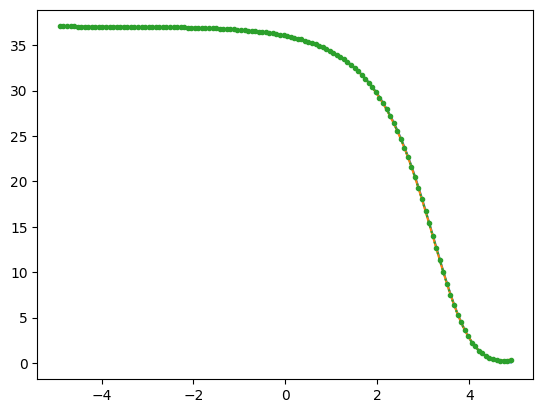

In [4]:
x = instance.x
plt.plot(x,ex)
plt.plot(x,exp[N//2:])
plt.plot(x,c[N//2:N],'.:')
plt.show()

### Tests opti CNOTs

In [5]:
import pennylane as qml

dev = qml.device("default.qubit",4)

# @qml.transforms.cancel_inverses()
# @qml.qnode(dev)
def c(x):
    qml.CNOT([3,4])
    qml.CNOT([2,4])
    qml.CNOT([3,4])
    if x==0:
        qml.CNOT([0,1])
        qml.CNOT([0,1])
        qml.CNOT([0,1])
    return qml.expval(qml.PauliZ(0))
    
c_ = qml.compile(c)
# c_ = qml.transforms.cancel_inverses(c)

qnode = qml.QNode(c, dev)
qnode_ = qml.QNode(c_, dev)

print(qml.draw(qnode)(0))
print(qml.draw(qnode_)(0))

0: ─╭●─╭●─╭●─┤  <Z>
1: ─╰X─╰X─╰X─┤     
2: ────╭●────┤     
3: ─╭●─│──╭●─┤     
4: ─╰X─╰X─╰X─┤     
0: ─╭●───────┤  <Z>
1: ─╰X───────┤     
2: ────╭●────┤     
3: ─╭●─│──╭●─┤     
4: ─╰X─╰X─╰X─┤     


In [6]:
dev = qml.device("default.qubit",4)
# @qml.qnode(dev)
def ccc(x):
    qml.AmplitudeEmbedding(x, range(4))
    qml.CNOT([0,2])
    qml.PauliX(1)
    qml.PauliX(1)
    return qml.probs(range(4))
def c(x):
    qml.AmplitudeEmbedding(x, range(4))
    qml.CNOT([1,2])
    qml.CNOT([0,2])
    qml.CNOT([1,2])
    return qml.probs(range(4))
    
x = np.random.rand(2**4)
x = x/np.linalg.norm(x)
a = c(x)

      
A = qml.matrix(c)(x)
B = qml.matrix(ccc)(x)
print(A@x - B@x)
# print(A)
# print(B)

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [7]:
def qfunc(x, y, z):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=0)
    qml.RX(x, wires=2)
    qml.RY(y, wires=1)
    qml.PauliX(wires=1)
    qml.RZ(z, wires=0)
    qml.RX(y, wires=2)
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 2])
    if x==1:
        qml.CNOT([0,1])
        qml.CNOT([0,1])
        qml.CNOT([0,1])
    qml.PauliX(wires=1)
    return qml.probs()

qnode = qml.QNode(qfunc, dev)
print(qml.draw(qnode)(1, 2, 3))

optimized_qfunc = qml.transforms.cancel_inverses(qfunc)
optimized_qnode = qml.QNode(optimized_qfunc, dev)
print(qml.draw(optimized_qnode)(1, 2, 3))

0: ──H─────────H─────────RZ(3.00)─╭●─╭●─╭●─╭●─╭●────┤  Probs
1: ──H─────────RY(2.00)──X────────│──│──╰X─╰X─╰X──X─┤  Probs
2: ──RX(1.00)──RX(2.00)───────────╰X─╰X─────────────┤  Probs
0: ──RZ(3.00)──────────────╭●────┤  Probs
1: ──H─────────RY(2.00)──X─╰X──X─┤  Probs
2: ──RX(1.00)──RX(2.00)──────────┤  Probs


In [8]:
def Print_naiveResources(circuit, args):
    dict_op = qml.specs(circuit)(*args)["resources"].gate_types
    count = 0
    for op,num in dict_op.items():
        if 'C' in op:
            count+=num
    print("Number of controlled gates (cnot + multicontrolled...) : ", count)

In [9]:

cnode = qml.QNode(instance.Circuit, instance.dev)
Print_naiveResources(cnode,[instance.get_coef_H(T), instance.get_coef_A(T), n, N//2,N//2, False])

c_compile = qml.compile(instance.Circuit)
c_compile_node = qml.QNode(c_compile, instance.dev)
Print_naiveResources(c_compile_node,[instance.get_coef_H(T), instance.get_coef_A(T), n, N//2,N//2, False])


cnode = qml.QNode(instance.Circuit, instance.dev)
Print_naiveResources(cnode,[instance.get_coef_H(T), instance.get_coef_A(T), n, N//2,N//2, True])

c_compile = qml.compile(instance.Circuit)
c_compile_node = qml.QNode(c_compile, instance.dev)
Print_naiveResources(c_compile_node,[instance.get_coef_H(T), instance.get_coef_A(T), n, N//2,N//2, True])

Number of controlled gates (cnot + multicontrolled...) :  2558
Number of controlled gates (cnot + multicontrolled...) :  2430
Number of controlled gates (cnot + multicontrolled...) :  2558
Number of controlled gates (cnot + multicontrolled...) :  2254


In [10]:
qml.specs(cnode)(instance.get_coef_H(T), instance.get_coef_A(T), n, N//2,N//2, True)["resources"].gate_types

defaultdict(int,
            {'RY': 212,
             'CNOT': 2558,
             'QFT': 1,
             'PauliZ': 1,
             'Adjoint(S)': 1,
             'Hadamard': 2,
             'RZ': 256,
             'S': 1,
             'Adjoint(QFT)': 1})

In [11]:
print(qml.draw(c_compile_node)(instance.get_coef_H(T), instance.get_coef_A(T), n, N//2,N//2, True))

0: ──RY(1.42)─────────────────────────────────────────────────────────────────────────────────────
1: ──RY(1.42)─────────────────────────────────────────────────────────────────────────────────────
2: ──RY(1.47)─────────────────────────────────────────────────────────────────────────────────────
3: ──RY(1.57)─────────────────────────────────────────────────────────────────────────────────────
4: ──RY(1.57)─────────────────────────────────────────────────────────╭X──RY(0.33)─╭X─╭X──RY(0.38)
5: ──RY(1.57)─────────────────────────╭X──RY(0.38)─╭X─╭X──RY(0.38)─╭X─╰●───────────│──╰●──────────
6: ──RY(1.57)─╭X──────────RY(0.34)─╭X─╰●───────────│──╰●───────────│───────────────╰●─────────────
7: ──RY(1.57)─╰●───────────────────╰●──────────────╰●──────────────╰●─────────────────────────────
8: ──Z─────────Rϕ(-1.57)──H───────────────────────────────────────────────────────────────────────
9: ───────────────────────────────────────────────────────────────────────────────────────────────

─────────

In [12]:

# Define your quantum circuit
def my_quantum_circuit(params, wires):
    qml.RX(params[0], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.RZ(params[2], wires=wires[2])
    return qml.expval(qml.PauliZ(0))

# Create a device and quantum function
dev = qml.device("default.qubit", wires=3)
quantum_function = qml.QNode(my_quantum_circuit, dev)

# Define a function to get the list of operators
def get_operator_list(qnode):
    operator_list = [op.name for op in qnode.qtape.operations]
    return operator_list

# Execute the quantum function
_ = quantum_function([0.1, 0.2, 0.3], wires=[0, 1, 2])

# Get the list of operators
operators = get_operator_list(quantum_function)
print("List of operators:", operators)

List of operators: ['RX', 'CNOT', 'RY', 'CNOT', 'CNOT', 'CNOT', 'RZ']


In [13]:
import pennylane as qml

# Define your quantum circuit
def my_quantum_circuit(params, wires):
    qml.RX(params[0], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.RZ(params[2], wires=wires[2])
    return qml.expval(qml.PauliZ(0))

# Create a device and quantum function
dev = qml.device("default.qubit", wires=3)
quantum_function = qml.QNode(my_quantum_circuit, dev)

# Execute the quantum function to build the quantum circuit
_ = quantum_function([0.1, 0.2, 0.3], wires=[0, 1, 2])

# Get the list of operators and the qubits they act on
operators = []
for op in quantum_function.qtape.operations:
    operators.append((op.name, op.wires))

print("Operators in the circuit:")
for op in operators:
    print("Operator:", op[0], "applied to qubits:", op[1])


Operators in the circuit:
Operator: RX applied to qubits: <Wires = [0]>
Operator: CNOT applied to qubits: <Wires = [0, 1]>
Operator: RY applied to qubits: <Wires = [1]>
Operator: CNOT applied to qubits: <Wires = [1, 2]>
Operator: CNOT applied to qubits: <Wires = [1, 2]>
Operator: CNOT applied to qubits: <Wires = [1, 2]>
Operator: RZ applied to qubits: <Wires = [2]>
